In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch
import torch.nn as nn
import torch.nn.functional as F

import utils, archimedean, extreme, importlib
import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

# https://github.com/bayesiains/nflows

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

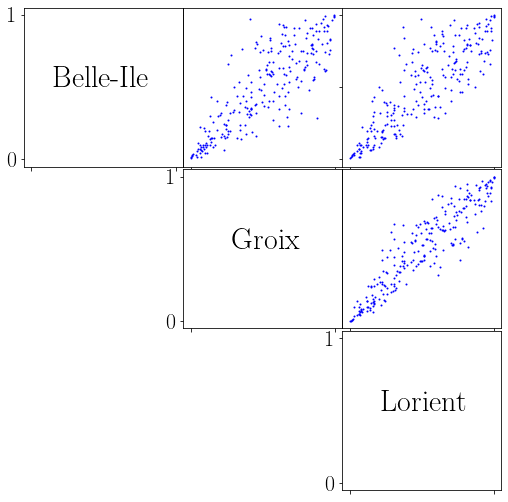

<Figure size 432x288 with 0 Axes>

In [2]:
nsamples = 240 # monthly maxima
ndims = 3

path = './data/synthetic/CNSD_C_1_14.p'
U0 = utils.load_data_0(path).float();
 
labels = ["Belle-Ile", "Groix", "Lorient"]
utils.plot_U(U0, labels=labels)

stdf = extreme.stdfNSD(alpha = torch.tensor([1.,2.,3.]), rho = torch.tensor([-0.69]))

In [3]:
num_layers = 2
base_dist = StandardNormal(shape=[ndims])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=ndims))
    transforms.append(MaskedAffineAutoregressiveTransform(features=ndims, hidden_features=128))
transform = CompositeTransform(transforms)

In [4]:
flow = Flow(transform, base_dist)
optimizer = torch.optim.Adam(flow.parameters(), lr = 1e-3)

n_batch = 200
n_iter = 5100

loss_array = np.zeros(n_iter)
time_array = np.zeros(int(n_iter/100))
iter_array = np.zeros(int(n_iter/100))
time_taken = 0
    
for iter_stdf in range(n_iter):
    
    data = U0[np.random.randint(0,nsamples,n_batch),:].detach()
    
    time_start = time.time()
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=data).mean()
    loss.backward()
    optimizer.step()

    time_end = time.time()
    time_taken += (time_end-time_start)

    loss_array[iter_stdf] = loss.item()
    
    if iter_stdf % 100 == 0:

        time_array[int(iter_stdf/100)] = time_taken
        iter_array[int(iter_stdf/100)] = iter_stdf
        print(iter_stdf, time_taken, loss.item())

0 0.18775606155395508 4.785512447357178
100 0.9608187675476074 -1.3690966367721558
200 1.7342116832733154 -1.3527315855026245
300 2.5071797370910645 -1.5459867715835571
400 3.25490140914917 -1.4884779453277588
500 4.014378547668457 -1.5344970226287842
600 4.895941257476807 -1.6445077657699585
700 6.3729541301727295 -1.8696805238723755
800 7.464127063751221 -1.6251126527786255
900 8.86009430885315 -1.699988842010498
1000 10.024893760681152 -1.580519676208496
1100 11.077555656433105 -1.9155981540679932
1200 12.48851203918457 -1.797181248664856
1300 13.479779958724976 -1.7415757179260254
1400 15.022764444351196 -1.902214765548706
1500 15.987167596817017 -1.6964689493179321
1600 17.558677911758423 -1.7181806564331055
1700 18.475769996643066 -1.810633897781372
1800 19.827685356140137 -1.857296109199524
1900 21.015142917633057 -1.6279913187026978
2000 22.255025386810303 -1.850276231765747
2100 23.50645422935486 -1.9430314302444458
2200 24.47264528274536 -1.9764552116394043
2300 26.0061230659

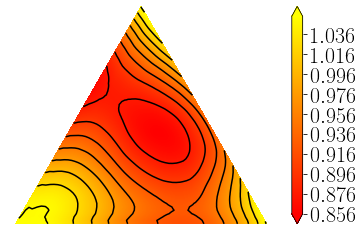

0.3327304720878601


In [5]:
# block maximas and compute IRAE

fake = flow.sample(200000)

Uev = fake.view(100,2000,ndims).max(dim=0)[0].detach().numpy()
for i in range(ndims):
    Uev[:, i] = scipy.stats.rankdata(Uev[:, i], 'ordinal')/2000
utils.plot_stdf3(extreme.stdfCFG(torch.tensor(Uev)))

U_test = utils.rand_simplex(10000,ndims)

stdfmax = extreme.stdfCFG(torch.tensor(Uev))(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)